In [ ]:
!wget https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
!unzip individual+household+electric+power+consumption.zip

--2025-06-13 08:37:28--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘individual+household+electric+power+consumption.zip’

individual+househol     [    <=>             ]  19.68M  28.1MB/s    in 0.7s    

2025-06-13 08:37:29 (28.1 MB/s) - ‘individual+household+electric+power+consumption.zip’ saved [20640916]

Archive:  individual+household+electric+power+consumption.zip
  inflating: household_power_consumption.txt  


In [ ]:
pip install Groq

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from groq import Groq
import json
import re
import os

In [2]:
Groq_api_key = 'api_key'
client =Groq(api_key=Groq_api_key)

In [3]:
#Load and and preprocess the dataset
def load_data_set():
    df = pd.read_csv('dataset/household_power_consumption.txt',
             	sep=';',
             	parse_dates={'datetime': ['Date', 'Time']},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')
    return df

In [4]:
# Function to generate pandas code from natural language question using GROQ API

def generate_pandas_code(natural_language_question, model_name, df_info):
    df_info_str = json.dumps(df_info)

    prompt = f"""
        You are a Python pandas and matplotlib expert. Given this preprocessed dataframe (index=datetime):

        PREPROCESSING CODE:
    
         df = pd.read_csv('dataset/household_power_consumption.txt',
             	sep=';',
             	parse_dates={{'datetime': {{'Date', 'Time'}}}},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

        df = df.dropna()
        df['Global_active_power'] = df['Global_active_power'].astype(float)
        df = df.set_index('datetime')
        
        Columns: {df_info_str}
        
        Generate ONLY executable Python/pandas code that:
        1. Answers the question: "{natural_language_question}"
        2. Stores final results in these standard variables when applicable:
           - avg_power_march, max_hour, weekday_avg, weekend_avg 
           - days_exceeded_5_kwh, daily_voltage, correlation
           - plot_data (for visualization outputs only)
        
        ONLY FOR VISUALIZATION QUERIES WHEN QUESTION CONTAINS KEY-WORDS like "plot", "visualize", "graph", "visualization":
            1. MUST include these elements in order:
               a) Data filtering/processing
               b) plt.figure() with size (10,6)
               c) ACTUAL PLOTTING COMMAND (plt.plot, plt.bar, etc.)
               d) Axis labels and title (plt.xlabel, plt.ylabel, plt.title)
               e) Save to "images/{model_name}/[sanitized_title].png"
               f) Buffer handling for plot_data
               g) plt.show()
               h) plt.close()
        
        EXAMPLE FOR QUESTION CONTAIN VISUALIZATION i.e "Plot the energy usage trend for the first week of January 2007."
        ```python
        # Filter data
        filtered = df[(df.index.year==2007) & (df.index.month==1)]
        daily = filtered['Global_active_power'].resample('D').mean()
        
        # Create plot
        plt.figure(figsize=(10,6))
        plt.plot(daily.index, daily, color='blue')  # <-- ACTUAL PLOT COMMAND
        plt.xlabel('Date')
        plt.ylabel('Power (kW)')
        title = 'January 2007 Daily Power Consumption'
        plt.title(title)
        
        # Save and store
        os.makedirs(f"images/{model_name}", exist_ok=True)
        filename = title.lower().replace(' ','_') + '.png'
        plt.savefig(f"images/{model_name}/filename.png")
        buf = io.BytesIO()
        buf.seek(0)
        plot_data = buf.getvalue()
        plt.show()
        plt.close()

        IMPORTANT RULES:
        (.)NEVER skip the actual plotting command (plt.plot, plt.bar, etc.) whereever needed if QUESTION CONTAIN KEY-WORDS.
        (.)show the plot (plt.show()) only for visual questions
        (.)Generate ONLY code - no explanations or markdown formatting
        (.)For non-visual questions, NEVER include plotting code AND ALWAYS PRINT THE FINAL RESULT.
    """
    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model=model_name,
            temperature=0.1,
        )
        return chat_completion.choices[0].message.content

    except Exception as e:
        print(f"GROQ API error: {e}")
        return None

In [5]:
# Function to execute the generated pandas code and display the output

def execute_query(query,model_name,df):
    df_info = {'columns': df.columns.tolist()}
    local_vars={}

    code = generate_pandas_code(query,model_name,df_info)
    #print("Python panda code is: \n",code)

    # Clean the code by removing markdown formatting so that it can be executed
    if code:
        code_clean = re.sub(r"```(?:python)?\n?|```", "", code).strip()
        code_clean = re.sub(r"<think>.*?</think>", "", code_clean, flags=re.DOTALL).strip()
        code_clean = code_clean.strip().split('\n')
        valid_lines = []
        for line in code_clean:
            # Include lines that look like real Python code (simple heuristic)
            if line.strip().startswith(("print", "df", "#", "import", "average", "result")) or "=" in line:
                valid_lines.append(line)

        final_code = '\n'.join(valid_lines)
        fixed_code = re.sub(
            r"df\[(df\.index\.\w+\s*==\s*\d+)\]\[(df\.index\.\w+\s*==\s*\d+)\]",
            r"df[(\1) & (\2)]",
            final_code
        )
        print("------------------------------------------------------------------------\nPython pandas Code is:\n\n", fixed_code)

    try:
        print("------------------------------------------------------------------------\nOutput of the code is:\n")
        exec_vars={'df':df,'plt':plt,'os':os}
        exec(fixed_code, exec_vars,local_vars) #execute the code in the context of the dataframe
         # Check if a plot was attempted but has 0 axes
        if 'plt' in exec_vars:
            fig = plt.gcf()
            if len(fig.axes) == 0 and any(line.strip().startswith(('plt.plot', 'plt.bar', 'plt.figure')) 
                                       for line in fixed_code.split('\n')):
                plt.close()
                print("Plot generation failed - empty figure detected")
                return False
        return True
    except Exception as e:
        print(f"Error executing code: {e}")
        return False

In [6]:
df = load_data_set()

In [7]:
print(df)

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

           

In [8]:
print(df.columns.tolist())
gemma_results={}

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


# Consider for Analysis

In [ ]:
#gemma2-9b-it Model Testing

In [9]:
value= execute_query("What was the average active power consumption in March 2007?","gemma2-9b-it",df)
if(value):
    gemma_results["What was the average active power consumption in March 2007?"]=1
else:
    gemma_results["What was the average active power consumption in March 2007?"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 avg_power_march = df[(df.index.year == 2007) & (df.index.month == 3)]['Global_active_power'].mean()
------------------------------------------------------------------------
Output of the code is:

True


<Figure size 640x480 with 0 Axes>

In [10]:
value= execute_query("What hour of the day had the highest power usage on Christmas 2006?","gemma2-9b-it",df)
if(value):
    gemma_results["What hour of the day had the highest power usage on Christmas 2006?"]=1
else:
    gemma_results["What hour of the day had the highest power usage on Christmas 2006?"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 christmas_2006 = df[df.index.year == 2006 & df.index.month == 12]
hourly_power = christmas_2006['Global_active_power'].resample('H').sum()
max_hour = hourly_power.idxmax()
print(max_hour)
------------------------------------------------------------------------
Output of the code is:

Error executing code: unsupported operand type(s) for &: 'int' and 'Int64Index'
False


------------------------------------------------------------------------
Python pandas Code is:

 df['day_of_week'] = df.index.dayofweek
weekday_mask = df['day_of_week'].isin([0,1,2,3,4])
weekend_mask = df['day_of_week'].isin([5,6])
weekday_avg = df.loc[weekday_mask, 'Global_active_power'].mean()
weekend_avg = df.loc[weekend_mask, 'Global_active_power'].mean()
print(f"Weekday average power: {weekday_avg:.2f} kW")
print(f"Weekend average power: {weekend_avg:.2f} kW")
# Plot energy usage on weekdays vs weekends
plt.figure(figsize=(10,6))
plt.bar(['Weekday', 'Weekend'], [weekday_avg, weekend_avg], color=['blue', 'red'])
------------------------------------------------------------------------
Output of the code is:

Weekday average power: 1.04 kW
Weekend average power: 1.23 kW
True


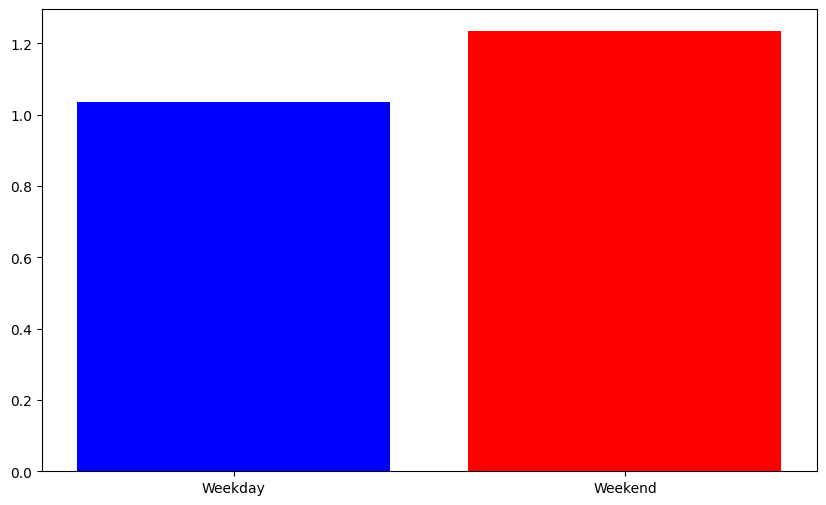

In [11]:
value = execute_query("Compare energy usage (Global_active_power) on weekdays vs weekends.","gemma2-9b-it",df)
if(value):
    gemma_results["Compare energy usage (Global_active_power) on weekdays vs weekends"]=1
else:
    gemma_results["Compare energy usage (Global_active_power) on weekdays vs weekends"]=0
print(value)

In [12]:
execute_query("Find days where total energy consumption exceeded 5 kWh.","gemma2-9b-it",df)
if(value):
    gemma_results["Find days where total energy consumption exceeded 5 kWh"]=1
else:
    gemma_results["Find days where total energy consumption exceeded 5 kWh"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 days_exceeded_5_kwh = df[df['Global_active_power'] > 5].index 
print(days_exceeded_5_kwh)
------------------------------------------------------------------------
Output of the code is:

DatetimeIndex(['2006-12-16 17:25:00', '2006-12-16 17:26:00',
               '2006-12-16 17:27:00', '2006-12-16 17:35:00',
               '2006-12-16 17:36:00', '2006-12-16 17:37:00',
               '2006-12-16 17:44:00', '2006-12-16 17:45:00',
               '2006-12-16 17:46:00', '2006-12-16 17:47:00',
               ...
               '2010-11-22 18:35:00', '2010-11-22 18:36:00',
               '2010-11-22 18:37:00', '2010-11-22 18:38:00',
               '2010-11-22 18:39:00', '2010-11-22 18:40:00',
               '2010-11-22 18:41:00', '2010-11-24 07:50:00',
               '2010-11-24 07:51:00', '2010-11-25 07:21:00'],
              dtype='datetime64[ns]', name='datetime', length=17547, freq=None)
True


<Figure size 640x480 with 0 Axes>

------------------------------------------------------------------------
Python pandas Code is:

 df['day_of_week'] = df.index.day_of_week
weekday_mask = df['day_of_week'] < 5
weekend_mask = df['day_of_week'] >= 5
weekday_avg = df[weekday_mask]['Global_active_power'].mean()
weekend_avg = df[weekend_mask]['Global_active_power'].mean()
plt.figure(figsize=(10,6))
plt.bar( ['Weekday', 'Weekend'], [weekday_avg, weekend_avg], color=['blue', 'red'])
------------------------------------------------------------------------
Output of the code is:



True

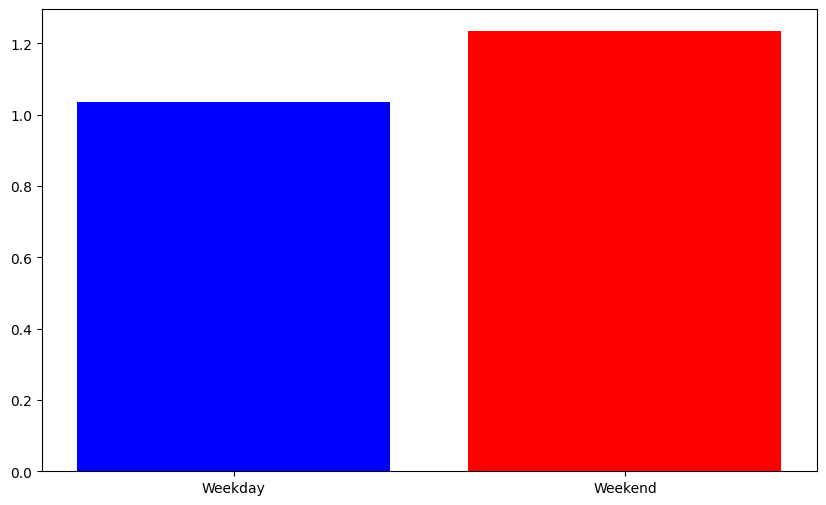

In [13]:
execute_query("Compare energy usage (Global_active_power) on weekdays vs weekends. Can you show it using visualizatio tool","gemma2-9b-it",df)

In [14]:
value= execute_query("Plot the energy usage trend for the first week of January 2007. Can you aggregate data by month","gemma2-9b-it",df)
if(value):
    gemma_results["Plot the energy usage trend for the first week of January 2007. Can you aggregate data by month"]=1
else:
    gemma_results["Plot the energy usage trend for the first week of January 2007. Can you aggregate data by month"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 df['day_of_week'] = df.index.day_of_week
weekday_avg = df[df['day_of_week'].isin([0,1,2,3,4])]['Global_active_power'].mean()
weekend_avg = df[df['day_of_week'].isin([5,6])]['Global_active_power'].mean()
print(weekday_avg)
print(weekend_avg)
------------------------------------------------------------------------
Output of the code is:

1.0354720516747509
1.234232176791304
True


<Figure size 640x480 with 0 Axes>

In [15]:
value = execute_query("Find the average voltage for each day of the first week of February 2007.","gemma2-9b-it",df)
if(value):
    gemma_results["Find the average voltage for each day of the first week of February 2007"]=1
else:
    gemma_results["Find the average voltage for each day of the first week of February 2007"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 df[(df.index.year == 2007) & (df['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) & (df.index.month == 2)].groupby('day_of_week')['Voltage'].mean()
------------------------------------------------------------------------
Output of the code is:

True


<Figure size 640x480 with 0 Axes>

In [16]:
value= execute_query("What is the correlation between global active power and sub-metering values?","gemma2-9b-it",df)
if(value):
    gemma_results["What is the correlation between global active power and sub-metering values?"]=1
else:
    gemma_results["What is the correlation between global active power and sub-metering values?"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 correlation = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()
print(correlation)
------------------------------------------------------------------------
Output of the code is:

                     Global_active_power  Sub_metering_1  Sub_metering_2  \
Global_active_power             1.000000        0.484401        0.434569   
Sub_metering_1                  0.484401        1.000000        0.054721   
Sub_metering_2                  0.434569        0.054721        1.000000   
Sub_metering_3                  0.638555        0.102571        0.080872   

                     Sub_metering_3  
Global_active_power        0.638555  
Sub_metering_1             0.102571  
Sub_metering_2             0.080872  
Sub_metering_3             1.000000  
True


<Figure size 640x480 with 0 Axes>

In [18]:
value= execute_query("What is the correlation between global active power and sub-metering values?. Can you show it using visualization","gemma2-9b-it",df)
if(value):
    gemma_results["What is the correlation between global active power and sub-metering values?. Can you show it using visualization"]=1
else:
    gemma_results["What is the correlation between global active power and sub-metering values?. Can you show it using visualization"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
import io
correlation = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()
print(correlation)
plt.figure(figsize=(10,6))
buf = io.BytesIO()
plot_data = buf.getvalue()
------------------------------------------------------------------------
Output of the code is:

                     Global_active_power  Sub_metering_1  Sub_metering_2  \
Global_active_power             1.000000        0.484401        0.434569   
Sub_metering_1                  0.484401        1.000000        0.054721   
Sub_metering_2                  0.434569        0.054721        1.000000   
Sub_metering_3                  0.638555        0.102571        0.080872   

                     Sub_metering_3  
Global_active_power        0.638555  
Sub_metering_1             0.102571  
Sub_metering_2             0.080872  
Sub_metering_3 

------------------------------------------------------------------------
Python pandas Code is:

 filtered = df[(df.index.year == 2007) & (df.index.month == 1) & (df.index.day >= 1) & (df.index.day <= 7)]
daily = filtered['Global_active_power'].resample('D').mean()
plt.figure(figsize=(10,6))
plt.plot(daily.index, daily, color='blue')  
os.makedirs(f"images/gemma2-9b-it", exist_ok=True)
filename = 'january_2007_daily_power_consumption.png'
buf = io.BytesIO()
plot_data = buf.getvalue()
------------------------------------------------------------------------
Output of the code is:

Error executing code: name 'io' is not defined
False


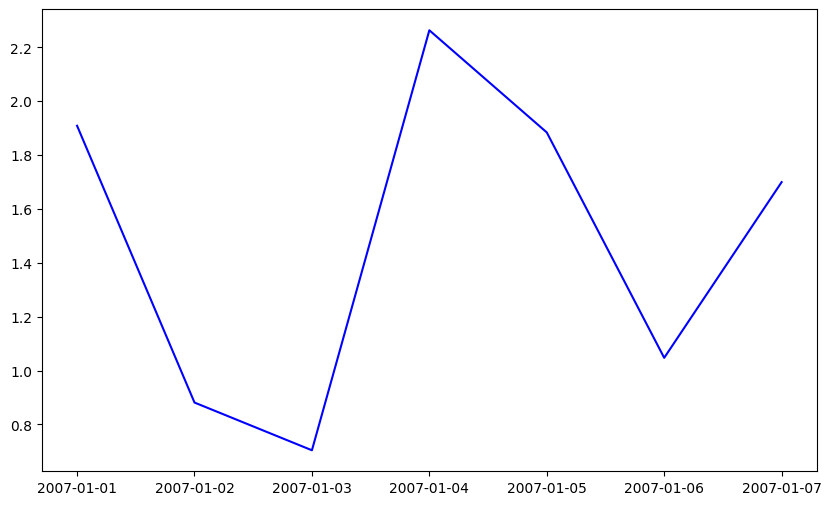

In [19]:
value = execute_query("Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day","gemma2-9b-it",df)
if(value):
    gemma_results["Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day"]=1
else:
    gemma_results["Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day"]=0
print(value)

In [20]:
execute_query("Find the average voltage for each day of the first week of February 2008","gemma2-9b-it",df)

------------------------------------------------------------------------
Python pandas Code is:

 df['day_of_week'] = df.index.day_of_week
filtered_df = df[(df.index.year == 2008) & (df.index.month == 2) & (df.index.dayofweek < 5)]
avg_voltage = filtered_df['Voltage'].groupby(df['day_of_week']).mean()
print(avg_voltage)
------------------------------------------------------------------------
Output of the code is:

day_of_week
0    240.946835
1    240.257382
2    240.210130
3    240.597507
4    240.431650
Name: Voltage, dtype: float64


True

<Figure size 640x480 with 0 Axes>

In [21]:
execute_query("Find the average voltage for each day of the first week of February 2008","llama-3.3-70b-versatile",df)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for the first week of February 2008
filtered = df[(df.index.year==2008) & (df.index.month==2) & (df.index.day<=7)]
# Calculate average voltage for each day of the first week of February 2008
daily_voltage = filtered['Voltage'].resample('D').mean()
# Print the final result
print(daily_voltage)
# Store the result in the standard variable
daily_voltage = daily_voltage
------------------------------------------------------------------------
Output of the code is:

datetime
2008-02-01    240.360271
2008-02-02    240.290514
2008-02-03    240.340722
2008-02-04    240.255208
2008-02-05    240.976917
2008-02-06    238.413715
2008-02-07    241.070549
Freq: D, Name: Voltage, dtype: float64


True

<Figure size 640x480 with 0 Axes>

In [22]:
for k,v in gemma_results.items():
    print(k,": ",v)

What was the average active power consumption in March 2007? :  1
What hour of the day had the highest power usage on Christmas 2006? :  0
Compare energy usage (Global_active_power) on weekdays vs weekends :  1
Find days where total energy consumption exceeded 5 kWh :  1
Plot the energy usage trend for the first week of January 2007. Can you aggregate data by month :  1
Find the average voltage for each day of the first week of February 2007 :  1
What is the correlation between global active power and sub-metering values? :  1
What is the correlation between global active power and sub-metering values?. Can you show it using visualization :  0
Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day :  0


In [2]:
%store gemma_results

Stored 'gemma_results' (dict)
